In [35]:
# Full training and SHAP analysis for my model

import numpy as np
import tensorflow as tf
from Library_Block import Block
from Library_Net import Net
import Library_load_and_split_data
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import matplotlib.colors as mcolors

In [10]:
# Section 1: Data Loading
cr = 8
window = 512
Noise = False
NL = -1
sens = 8
coeff = 64
tw = 64

# Load preloaded data
X, Y = Library_load_and_split_data.load_preloaded_data(CR=cr, W=window, Noise=Noise, Noise_level=NL, datasetName="Z24")
Xd = Library_load_and_split_data.reshape_data_keras(X, cr=cr, window=window, nsens=sens)
Yd = Y

In [15]:
# Section 2: Train-test split
fold_train_ind, fold_test_ind = Library_load_and_split_data.fold_index(X)

# Concatenate the arrays in fold_train_ind and fold_test_ind
fold_train_flat = np.concatenate(fold_train_ind)
fold_test_flat = np.concatenate(fold_test_ind)

# Apply train-test split using the concatenated indices
X_train = Xd[fold_train_flat]
Y_train = Yd[fold_train_flat]
X_test = Xd[fold_test_flat]
Y_test = Yd[fold_test_flat]

# Print shapes after splitting to verify
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (22604, 64, 64, 8), Y_train shape: (22604, 1)
X_test shape: (5651, 64, 64, 8), Y_test shape: (5651, 1)


In [19]:
# Section 3: Define the model blocks using Block class
b1 = Block(n_filters=19, kernel_size=2, activation="relu", padding="same", is_pool=False, input_size=64)
b2 = Block(n_filters=26, kernel_size=1, activation="relu", padding="same", is_pool=True, input_size=64, is_dropout=True)
b3 = Block(n_filters=5, kernel_size=1, activation="relu", padding="same", is_pool=False, input_size=32)
b4 = Block(n_filters=6, kernel_size=5, activation="relu", padding="same", is_pool=False, input_size=32)
b5 = Block(n_filters=19, kernel_size=1, activation="relu", padding="same", is_pool=True, input_size=32, is_dropout=True)
b6 = Block(n_filters=12, kernel_size=1, activation="relu", padding="same", is_pool=True, input_size=16, is_dropout=True)

# Initialize the Net model with block_list
model = Net(cr, window, coeff, tw, sens, [b1, b2, b3, b4, b5, b6])

# Get the keras model
keras_model = model.ins_keras_model()

In [23]:
# Section 3: Run the model & save it
%run TII_train_net_from_description.py 

[82740, 131072, -7]
Epoch 1/100
14/14 [==============================] - 1s 45ms/step - loss: 0.7112 - val_loss: 0.6289 - lr: 0.0010
Epoch 2/100
14/14 [==============================] - 0s 20ms/step - loss: 0.6037 - val_loss: 0.5822 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 0.5471 - val_loss: 0.5363 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 0s 24ms/step - loss: 0.4879 - val_loss: 0.4778 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 0s 20ms/step - loss: 0.4162 - val_loss: 0.4009 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.3534 - val_loss: 0.3327 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 0s 19ms/step - loss: 0.2961 - val_loss: 0.2888 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 0s 22ms/step - loss: 0.2625 - val_loss: 0.2723 - lr: 0.0010
Epoch 9/100
14/14 [==============================] - 0s 19ms/step - loss: 0.

In [24]:
# Load the trained model from the saved .h5 file
trained_model = load_model('trained_model.h5')

In [33]:
# Section 4: SHAP Analysis
# Limit the number of test samples for SHAP analysis to speed up computation
sample_size = 100  # Set this to a smaller number to reduce SHAP computation time
X_test_subset = X_test[:sample_size]  # Use only a subset of test data

# Initialize SHAP DeepExplainer for the trained keras model
explainer = shap.DeepExplainer(trained_model, X_train[:100])  # Use a subset of training data for explainer initialization

# Calculate SHAP values for the subset of test data
shap_values = explainer.shap_values(X_test_subset)

# Check the shape of SHAP values (for debugging purposes)
print(f"SHAP values shape: {np.array(shap_values).shape}")  # Should be (100, 64, 64, 8, 2)

SHAP values shape: (100, 64, 64, 8, 2)


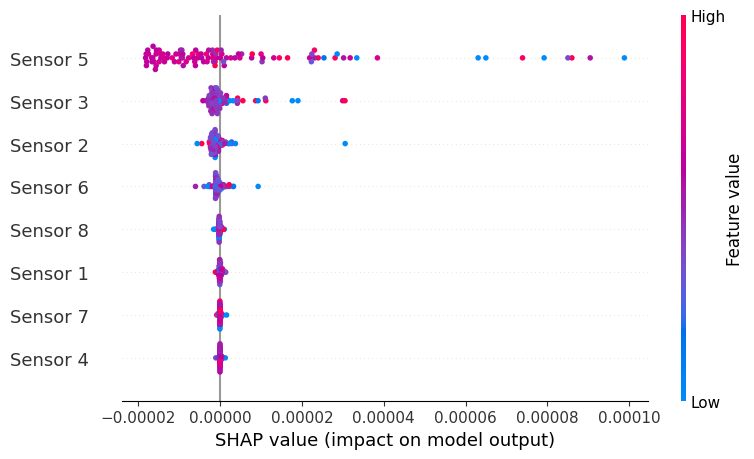

In [34]:
# Section 5: Visualization of SHAP values
# Average the SHAP values over the spatial dimensions only (axes 1 and 2), keeping the sensor dimension (axis 3)
shap_values_2d = np.mean(shap_values, axis=(1, 2))  # This reduces the shape to (100, 8, 2)

# If you have multiple outputs (2 in this case), you may need to select one output to visualize, e.g.,:
shap_values_2d = shap_values_2d[..., 0]  # Select the first output, reducing shape to (100, 8)

# Ensure that X_test_subset is averaged similarly to match the SHAP values
X_test_subset_reduced = np.mean(X_test_subset, axis=(1, 2))  # Average over spatial dimensions to get (100, 8)

# Now, create the SHAP summary plot using the reduced SHAP values and the averaged test data
shap.summary_plot(shap_values_2d, X_test_subset_reduced, feature_names=['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8'])

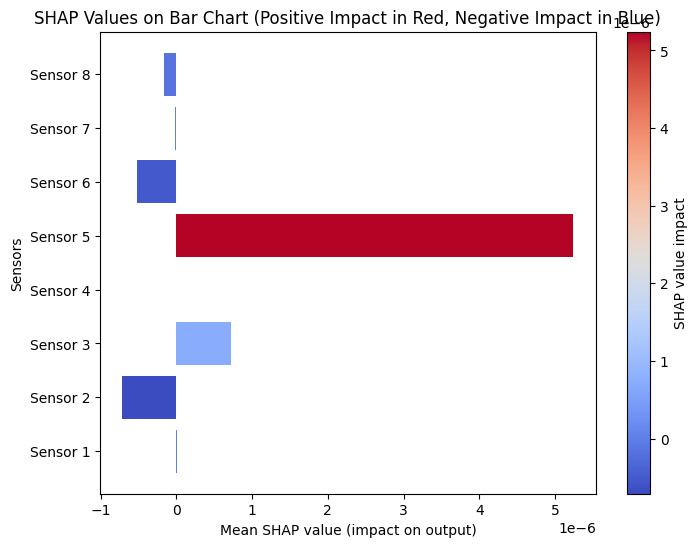

In [37]:
# Section 6: SHAP Directed Bar Chart Visualization

# Calculate the mean absolute SHAP values for each sensor across all samples
shap_mean = np.mean(shap_values_2d, axis=0)

# Set up the color mapping: red for positive, blue for negative
cmap = plt.get_cmap("coolwarm")
norm = mcolors.Normalize(vmin=min(shap_mean), vmax=max(shap_mean))  # Normalize colors based on SHAP values

# Create the bar colors based on SHAP values: red for positive, blue for negative
colors = [cmap(norm(value)) for value in shap_mean]

# Create the figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the horizontal bar chart
bars = ax.barh(['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8'],
               shap_mean, color=colors)

# Add color bar to show the SHAP value range
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar to the same figure
fig.colorbar(sm, ax=ax, label="SHAP value impact")

# Set axis labels and title
ax.set_xlabel('Mean SHAP value (impact on output)')
ax.set_ylabel('Sensors')
ax.set_title('SHAP Values on Bar Chart (Positive Impact in Red, Negative Impact in Blue)')

# Show the plot
plt.show()